In [1]:
#GPU 체크
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('실패') >= 0:
  print('GPU 없음')
else:
  print(gpu_info)

Mon Apr 29 09:49:46 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 552.22                 Driver Version: 552.22         CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                     TCC/WDDM  | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 3070 ...  WDDM  |   00000000:01:00.0 Off |                  N/A |
| N/A   46C    P0             30W /  138W |       0MiB /   8192MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [43]:
#허깅페이스 허브 로그인

from huggingface_hub import notebook_login

notebook_login()

In [3]:
%%capture
!apt install git-lfs

## 2.&nbsp;데이터 로드

In [4]:
from datasets import load_dataset, load_metric, Audio
zeroth_data = load_dataset("kresnik/zeroth_korean", 'clean', trust_remote_code=True)

Generating train split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

In [5]:
zeroth_data

DatasetDict({
    train: Dataset({
        features: ['file', 'audio', 'text', 'speaker_id', 'chapter_id', 'id'],
        num_rows: 22263
    })
    test: Dataset({
        features: ['file', 'audio', 'text', 'speaker_id', 'chapter_id', 'id'],
        num_rows: 457
    })
})

In [ ]:
#전처리

In [6]:
zeroth_data = zeroth_data.remove_columns(['speaker_id', 'chapter_id', 'id'])

In [7]:
zeroth_data

DatasetDict({
    train: Dataset({
        features: ['file', 'audio', 'text'],
        num_rows: 22263
    })
    test: Dataset({
        features: ['file', 'audio', 'text'],
        num_rows: 457
    })
})

In [8]:
from datasets import ClassLabel
import random
import pandas as pd
from IPython.display import display, HTML
def show_random_elements(dataset, num_examples=10):
    assert num_examples <= len(dataset), "Can't pick more elements than there are in the dataset."
    picks = []
    for _ in range(num_examples):
        pick = random.randint(0, len(dataset)-1)
        while pick in picks:
            pick = random.randint(0, len(dataset)-1)
        picks.append(pick)
    df = pd.DataFrame(dataset[picks])
    display(HTML(df.to_html()))

In [9]:
show_random_elements(zeroth_data["train"].remove_columns(["file", "audio"]), num_examples=10)

,text
0,그래서 결국 죽음을 선택한 그런 사건도 있었는데 이런 문제를 해결하기 위해서는 부양의무자 기준이 폐지되지 않고는 가능하지 않다고 봅니다
1,여덟 명만 불러서 조사하고 말아서는 안되는 것 아닌가라고 말했다
2,한국지엠의 경차 스파크에게 이 월 삼 월 두 달 연속 일 위 자리를 뺏겼다
3,학습 장애의 증상 가운데는 말을 배우는 것이 늦거나 습관적으로 잘못 발음하거나 어린애 같은 말투를 계속 쓰는 것이 있습니다
4,사우스캐롤리아 주 해상으로 이동 중인 매슈는 여전히 시속 백 예순 킬로미터의 강풍을 동반하고 있습니다
5,이천 십 삼 년 가벼운 위염이 있는 감염자에게로 확대하자 한 해 백 마흔 만명으로 뛰었다
6,우리는 위기의 진앙이 아닌 안전지대가 됐다는 말까지 나올 정도였다
7,한 걸음 더 나아가 천 구백 이십 이 년에는 처음으로 선박과 육지 사이에 무선 통신이 이루어졌습니다
8,한편 유상증자 발행주식 중 이십 퍼센트는 우리사주조합에 우선 배정되고 나머지 팔십 퍼센트는 구주주에 배정된다
9,이에 대해 한 건설사의 임원은 엘시티 더샵의 분양가는 솔직히 과하다며 현재 불안한 국내 부동산시장 상황을 볼 때 막바지 투기를 부추기는 것으로 보인다고 말했다


In [ ]:
#Wav2Vec2CTCTokenizer 토크나이저 + 한글 자모 

In [10]:
__all__ = ["split_syllable_char", "split_syllables",
           "join_jamos", "join_jamos_char",
           "CHAR_INITIALS", "CHAR_MEDIALS", "CHAR_FINALS"]

import itertools

INITIAL = 0x001
MEDIAL = 0x010
FINAL = 0x100
CHAR_LISTS = {
    INITIAL: list(map(chr, [
        0x3131, 0x3132, 0x3134, 0x3137, 0x3138, 0x3139,
        0x3141, 0x3142, 0x3143, 0x3145, 0x3146, 0x3147,
        0x3148, 0x3149, 0x314a, 0x314b, 0x314c, 0x314d,
        0x314e
    ])),
    MEDIAL: list(map(chr, [
        0x314f, 0x3150, 0x3151, 0x3152, 0x3153, 0x3154,
        0x3155, 0x3156, 0x3157, 0x3158, 0x3159, 0x315a,
        0x315b, 0x315c, 0x315d, 0x315e, 0x315f, 0x3160,
        0x3161, 0x3162, 0x3163
    ])),
    FINAL: list(map(chr, [
        0x3131, 0x3132, 0x3133, 0x3134, 0x3135, 0x3136,
        0x3137, 0x3139, 0x313a, 0x313b, 0x313c, 0x313d,
        0x313e, 0x313f, 0x3140, 0x3141, 0x3142, 0x3144,
        0x3145, 0x3146, 0x3147, 0x3148, 0x314a, 0x314b,
        0x314c, 0x314d, 0x314e
    ]))
}
CHAR_INITIALS = CHAR_LISTS[INITIAL]
CHAR_MEDIALS = CHAR_LISTS[MEDIAL]
CHAR_FINALS = CHAR_LISTS[FINAL]
CHAR_SETS = {k: set(v) for k, v in CHAR_LISTS.items()}
CHARSET = set(itertools.chain(*CHAR_SETS.values()))
CHAR_INDICES = {k: {c: i for i, c in enumerate(v)}
                for k, v in CHAR_LISTS.items()}


def is_hangul_syllable(c):
    return 0xac00 <= ord(c) <= 0xd7a3  # Hangul Syllables


def is_hangul_jamo(c):
    return 0x1100 <= ord(c) <= 0x11ff  # Hangul Jamo


def is_hangul_compat_jamo(c):
    return 0x3130 <= ord(c) <= 0x318f  # Hangul Compatibility Jamo


def is_hangul_jamo_exta(c):
    return 0xa960 <= ord(c) <= 0xa97f  # Hangul Jamo Extended-A


def is_hangul_jamo_extb(c):
    return 0xd7b0 <= ord(c) <= 0xd7ff  # Hangul Jamo Extended-B


def is_hangul(c):
    return (is_hangul_syllable(c) or
            is_hangul_jamo(c) or
            is_hangul_compat_jamo(c) or
            is_hangul_jamo_exta(c) or
            is_hangul_jamo_extb(c))


def is_supported_hangul(c):
    return is_hangul_syllable(c) or is_hangul_compat_jamo(c)


def check_hangul(c, jamo_only=False):
    if not ((jamo_only or is_hangul_compat_jamo(c)) or is_supported_hangul(c)):
        raise ValueError(f"'{c}' is not a supported hangul character. "
                         f"'Hangul Syllables' (0xac00 ~ 0xd7a3) and "
                         f"'Hangul Compatibility Jamos' (0x3130 ~ 0x318f) are "
                         f"supported at the moment.")


def get_jamo_type(c):
    check_hangul(c)
    assert is_hangul_compat_jamo(c), f"not a jamo: {ord(c):x}"
    return sum(t for t, s in CHAR_SETS.items() if c in s)


def split_syllable_char(c):
    check_hangul(c)
    if len(c) != 1:
        raise ValueError("한개만")

    init, med, final = None, None, None
    if is_hangul_syllable(c):
        offset = ord(c) - 0xac00
        x = (offset - offset % 28) // 28
        init, med,견: "
                             f"{c} (0x{ord(c):x})")

    s = map(try_split, s)
    if pad is not None:
        tuples = map(lambda x: tuple(pad if y is None else y for y in x), s)
    else:
        tuples = map(lambda x: filter(None, x), s)
    return "".join(itertools.chain(*tuples))


def join_jamos_char(init, med, final=None):
    chars = (init, med, final)
    for c in filter(None, chars):
        check_hangul(c, jamo_only=True)

    idx = tuple(CHAR_INDICES[pos][c] if c is not None else c
                for pos, c in zip((INITIAL, MEDIAL, FINAL), chars))
    init_idx, med_idx, final_idx = idx
    # final index must be shifted once as
    # final index with 0 points to syllables without final
    final_idx = 0 if final_idx is None else final_idx + 1
    return chr(0xac00 + 28 * 21 * init_idx + 28 * med_idx + final_idx)


def join_jamos(s, ignore_err=True):
    last_t = 0
    queue = []
    new_string = ""

    def flush(n=0):
        new_queue = []
        while len(queue) > n:
            new_queue.append(queue.pop())
        if len(new_queue) == 1:
            if not ignore_err:
                raise ValueError(f"invalid jamo character: {new_queue[0]}")
            result = new_queue[0]
        elif len(new_queue) >= 2:
            try:
                result = join_jamos_char(*new_queue)
            except (ValueError, KeyError):
                if not ignore_err:
                    raise ValueError(f"invalid jamo characters: {new_queue}")
                result = "".join(new_queue)
        else:
            result = None
        return result

    for c in s:
        if c not in CHARSET:
            if queue:
                new_c = flush() + c
            else:
                new_c = c
            last_t = 0
        else:
            t = get_jamo_type(c)
            new_c = None
            if t & FINAL == FINAL:
                if not (last_t == MEDIAL):
                    new_c = flush()
            elif t == INITIAL:
                new_c = flush()
            elif t == MEDIAL:
                if last_t & INITIAL == INITIAL:
                    new_c = flush(1)
                else:
                    new_c = flush()
            last_t = t
            queue.insert(0, c)
        if new_c:
            new_string += new_c
    if queue:
        new_string += flush()
    return new_string

In [11]:
import re
chars_to_ignore_regex = '[-=+,#/\?:^$.@*\"※~&%ㆍ!』\\‘|\(\)\[\]\<\>`\'…》]'
def remove_special_characters(batch):
    batch["text"] = re.sub(chars_to_ignore_regex, '', batch["text"]).lower() + " "
    batch['text'] = split_syllables(batch['text'])
    return batch

In [12]:
zeroth_data = zeroth_data.map(remove_special_characters)

Map:   0%|          | 0/22263 [00:00<?, ? examples/s]

Map:   0%|          | 0/457 [00:00<?, ? examples/s]

In [13]:
show_random_elements(zeroth_data["train"].remove_columns(["file", "audio"]), num_examples=10)

,text
0,ㅇㅏㄴㅊㅓㄹㅅㅜ ㅇㅢㅇㅝㄴㅇㅣ ㅈㅔㅇㅏㄴㅎㅏㄴ ㅎㅕㄱㅅㅣㄴ ㅈㅓㄴㄷㅏㅇㄷㅐㅎㅚ ㄱㅐㅊㅚㅇㅘ ㄱㅘㄴㄹㅕㄴ ㄷㅏㅇㄴㅐ ㄴㅗㄴㄹㅏㄴㅇㅣ ㅇㅣㄹㅈㅏ ㅁㅜㄴ ㄷㅐㅍㅛㅇㅢ ㅌㅚㅈㅣㄴㅇㅡㄹ ㅇㅛㄱㅜㅎㅏㄴ ㄱㅜㄷㅏㅇㅁㅗㅇㅣㅁㅇㅔ ㅇㅣㄹㅡㅁㅇㅡㄹ ㅇㅗㄹㄹㅣㄱㅣㄷㅗ ㅎㅐㅆㄷㅏ
1,ㄷㅏㄴㄷㅜㅇㅇㅔㅅㅓㄴ ㅌㅔㅅㅡㅌㅡㅁㅏㄴ ㅎㅏㄱㅗ ㅅㅏㅅㅣㄹ ㅇㅕㄱㅣㅅㅓㄴ ㅎㅐㅋㅓㄷㅡㄹㅇㅣ ㅎㅘㄹㄷㅗㅇ ㅇㅏㄴ ㅎㅐㅇㅛ
2,ㅅㅣㅂ ㅇㅣ ㅇㅣㄹ ㄱㅕㅇㅈㅜㅇㅔㅅㅓ ㅂㅏㄹㅅㅐㅇㅎㅏㄴ ㅈㅣㅈㅣㄴㅇㅡㄹㅗ ㅍㅗㅎㅏㅇㅅㅣ ㄴㅏㅁㄱㅜㅇㅢ ㅎㅏㄴ ㅁㅏㅌㅡ ㅈㅣㄴㅇㅕㄹㅈㅏㅇㅇㅔ ㅆㅏㅎㅇㅕ ㅇㅣㅆㄷㅓㄴ ㅅㅏㅇㅍㅜㅁㄷㅡㄹㅇㅣ ㅂㅏㄷㅏㄱㅇㅔ ㄸㅓㄹㅇㅓㅈㅕ ㅇㅣㅆㄷㅏ
3,ㄸㅏㅇㅋㅗㅇㅂㅗㅌㅡ ㅇㅜㄴㅇㅕㅇㅇㅓㅂㅊㅔㅇㅘ ㅁㅗㅌㅓㅂㅗㅌㅡ ㅇㅜㄴㅈㅓㄴㅈㅏㄴㅡㄴ ㅇㅜㄴㅇㅕㅇㅎㅓㄱㅏㅇㅘ ㅇㅜㄴㅈㅓㄴㅁㅕㄴㅎㅓㄴㅡㄴ ㄱㅏㅈㅊㅜㄴ ㄱㅓㅅㅇㅡㄹㅗ ㅎㅘㄱㅇㅣㄴㄷㅙㅆㄷㅏ
4,ㅇㅣㄹㅂㅜ ㅇㅓㅂㅈㅏㄴㅡㄴ ㅈㅐㅈㅣㄹㅇㅣ ㅂㅣㅅㅡㅅㅎㅏㄴ ㅇㅑㅇ ㄱㅏㅈㅜㄱㅇㅣㄹㅏㄱㅗ ㅅㅗㄱㅇㅕ ㅍㅏㄴㅁㅐㅎㅏㄱㅣㄷㅗ ㅎㅏㄴㅡㄴ ㄱㅓㅅㅇㅡㄹㅗ ㄷㅡㄹㅓㄴㅏㅆㅅㅡㅂㄴㅣㄷㅏ
5,ㅂㅗㄱㅈㅣㅎㅖㅌㅐㄱㅇㅡㄹ ㅁㅏㅈㅂㅓㄹㅇㅣ ㅂㅜㅂㅜㅇㅔㄱㅔ ㄷㅗㄹㅇㅏㄱㅏㄹ ㅅㅜ ㅇㅣㅆㄷㅗㄹㅗㄱ ㅈㅣㅇㅝㄴㅊㅐㄱㅇㅡㄹ ㄱㅐㅅㅓㄴㅎㅏㅈㅏ ㄹㅏㄴㅡㄴ ㄸㅡㅅㅇㅡㄹ ㅂㅏㄺㅎㅕㅆㅅㅡㅂㄴㅣㄷㅏ
6,ㄱㅘㄱㅓㅇㅔㄴㅡㄴ ㅊㅓㄴ ㅅㅏㅁㅂㅐㄱ ㅅㅏㅅㅣㅂ ㅈㅗ ㅇㅣㄹㅓㄴ ㅁㅏㄹㅁㅏㄴ ㄴㅏㅇㅘㅆㅈㅣㅁㅏㄴ ㅈㅣㄱㅡㅁ ㅇㅕㄴㄱㅜㅇㅟㅇㅝㄴㄲㅔㅅㅓㄷㅗ ㅈㅣㄹㅈㅓㄱ ㅊㅡㄱㅁㅕㄴㄲㅏㅈㅣ ㄱㅚㅇㅈㅏㅇㅎㅣ ㅇㅟㅎㅓㅁㅎㅏㄷㅏㄱㅗ ㅎㅐㅆㄱㅓㄷㅡㄴㅇㅛ
7,ㅂㅏㄱㅈㅐㅎㅗㅇ ㅇㅣㅇㅓㅅㅓ ㅋㅡㄹㅣㅁㅃㅏㅇ ㅃㅐㅇㅅㅗㄴㅣ ㅅㅏㄱㅓㄴ ㅅㅜㅅㅏㅇㅔ ㄷㅗㅇㅜㅁㅇㅡㄹ ㅈㅜㅅㅣㄱㅗ ㄱㅖㅅㅣㄴㅡㄴ ㄴㅔㅌㅣㅈㅡㄴㅇㅣㅂㄴㅣㄷㅏ
8,ㅇㅑㄱㅝㄴㅎㅜㅂㅗ ㄷㅏㄴㅇㅣㄹㅎㅘㅇㅔ ㄷㅐㅎㅐ ㄱㅡㄴㅡㄴ ㄱㅏㄱㄷㅏㅇㅇㅢ ㄱㅏㄱ ㅎㅜㅂㅗㄹㅡㄹ ㅇㅓㄸㅓㅎㄱㅔ ㅃㅗㅂㅇㅡㄹㅈㅣ ㄴㅏㅇㅘㅂㅘㅇㅑ ㅎㅏㄹ ㅇㅒㄱㅣㄷㅏ
9,ㄱㅏㅁㅅㅏㅇㅝㄴㅇㅡㄴ ㅅㅏ ㅇㅣㄹ ㅇㅣ ㄱㅏㅌㅇㅡㄴ ㄴㅐㅇㅛㅇㅇㅡㄹ ㄷㅏㅁㄱㅗ ㅇㅣㅆㄴㅡㄴ ㄱㅖㅇㅑㄱ ㅂㅜㄴㅇㅑ ㅎㅚㄱㅖㅂㅣㄹㅣ ㅌㅡㄱㅂㅕㄹㅈㅓㅁㄱㅓㅁㅇㅔ ㄷㅐㅎㅏㄴ ㄱㅏㅁㅅㅏ ㄱㅕㄹㄱㅘㄹㅡㄹ ㄱㅗㅇㄱㅐㅎㅐㅆㄷㅏ


In [14]:
def extract_all_chars(batch):
  all_text = " ".join(batch["text"])
  vocab = list(set(all_text))
  return {"vocab": [vocab], "all_text": [all_text]}

In [15]:
vocabs = zeroth_data.map(
    extract_all_chars,
    batched=True,
    batch_size=-1,
    keep_in_memory=True,
    remove_columns=zeroth_data.column_names["train"])

Map:   0%|          | 0/22263 [00:00<?, ? examples/s]

Map:   0%|          | 0/457 [00:00<?, ? examples/s]

In [16]:
vocab_list = list(set(vocabs["train"]["vocab"][0]) | set(vocabs["test"]["vocab"][0]))

In [17]:
vocab_dict = {v: k for k, v in enumerate(sorted(vocab_list))}
vocab_dict

{' ': 0,
 'ㄱ': 1,
 'ㄲ': 2,
 'ㄳ': 3,
 'ㄴ': 4,
 'ㄵ': 5,
 'ㄶ': 6,
 'ㄷ': 7,
 'ㄸ': 8,
 'ㄹ': 9,
 'ㄺ': 10,
 'ㄻ': 11,
 'ㄼ': 12,
 'ㅀ': 13,
 'ㅁ': 14,
 'ㅂ': 15,
 'ㅃ': 16,
 'ㅄ': 17,
 'ㅅ': 18,
 'ㅆ': 19,
 'ㅇ': 20,
 'ㅈ': 21,
 'ㅉ': 22,
 'ㅊ': 23,
 'ㅋ': 24,
 'ㅌ': 25,
 'ㅍ': 26,
 'ㅎ': 27,
 'ㅏ': 28,
 'ㅐ': 29,
 'ㅑ': 30,
 'ㅒ': 31,
 'ㅓ': 32,
 'ㅔ': 33,
 'ㅕ': 34,
 'ㅖ': 35,
 'ㅗ': 36,
 'ㅘ': 37,
 'ㅙ': 38,
 'ㅚ': 39,
 'ㅛ': 40,
 'ㅜ': 41,
 'ㅝ': 42,
 'ㅞ': 43,
 'ㅟ': 44,
 'ㅠ': 45,
 'ㅡ': 46,
 'ㅢ': 47,
 'ㅣ': 48}

In [18]:
vocab_dict["|"] = vocab_dict[" "]
del vocab_dict[" "]

In [19]:
vocab_dict["[UNK]"] = len(vocab_dict)
vocab_dict["[PAD]"] = len(vocab_dict)
len(vocab_dict)

51

In [20]:
import json
with open("vocab.json", 'w') as vocab_file:
    json.dump(vocab_dict, vocab_file)

In [22]:
from transformers import Wav2Vec2CTCTokenizer
tokenizer = Wav2Vec2CTCTokenizer("vocab.json", unk_token="[UNK]", pad_token="[PAD]", word_delimiter_token="|")

In [44]:
repo_name = "Ljrabbit/wav2vec2-large-xls-r-300m-korean-test0"

In [45]:
tokenizer.push_to_hub(repo_name)

CommitInfo(commit_url='https://huggingface.co/Ljrabbit/wav2vec2-large-xls-r-300m-korean-test0/commit/ded914fc5a95a3492cf6acde969566041e8d35b2', commit_message='Upload tokenizer', commit_description='', oid='ded914fc5a95a3492cf6acde969566041e8d35b2', pr_url=None, pr_revision=None, pr_num=None)

In [ ]:
#Wav2Vec2 Feature Extractor

In [28]:
from transformers import Wav2Vec2FeatureExtractor
feature_extractor = Wav2Vec2FeatureExtractor(feature_size=1, sampling_rate=16000, padding_value=0.0, do_normalize=True, return_attention_mask=False)
from transformers import Wav2Vec2Processor
processor = Wav2Vec2Processor(feature_extractor=feature_extractor, tokenizer=tokenizer)

In [ ]:
#Preprocess Data

In [29]:
zeroth_data["train"][0]["file"]

'C:/Users/User/.cache/huggingface/datasets/downloads/extracted/ced79e66418d9fe8058679e42f8eac8957dd37121e912335283d1e45da227fdf/train_data_01/003/106\\106_003_0077.flac'

In [30]:
zeroth_data["train"][0]["audio"]

{'path': 'C:/Users/User/.cache/huggingface/datasets/downloads/extracted/ced79e66418d9fe8058679e42f8eac8957dd37121e912335283d1e45da227fdf/train_data_01/003/106\\106_003_0077.flac',
 'array': array([-3.05175781e-05,  0.00000000e+00, -3.05175781e-05, ...,
         0.00000000e+00,  0.00000000e+00, -6.10351562e-05]),
 'sampling_rate': 16000}

In [31]:
import IPython.display as ipd
import numpy as np
import random
rand_int = random.randint(0, len(zeroth_data["train"]))
print(zeroth_data["train"][rand_int]["text"])
ipd.Audio(data=zeroth_data["train"][rand_int]["audio"]["array"], autoplay=True, rate=16000)

ㄱㅕㄴㅇㅣㄴㅇㅣ ㅂㅓㄴㄱㅓㄹㅗㅇㅜㄴ ㄱㅗㄱㅡㅂ ㅅㅜㅇㅣㅂㅊㅏㅇㅘ ㅅㅏ ㄹㅠㄴㄱㅜㄷㅗㅇㅊㅏㄴㅡㄴ ㄱㅕㄴㅇㅣㄴㅎㅏㅈㅣ ㅇㅏㄶㄴㅡㄴㄷㅏㄴㅡㄴ ㅂㅜㄹㅁㅜㄴㅇㅠㄹㅇㅣ ㄱㅗㅇㄱㅗㅇㅇㅕㄴㅎㅣ ㅍㅓㅈㅕ ㅇㅣㅆㄷㅏ 


In [69]:
rand_int = random.randint(0, len(zeroth_data["train"]))
print("Target text:",zeroth_data["train"][rand_int]["text"])
print("Input array shape:", np.asarray(zeroth_data["train"][rand_int]["audio"]["array"]).shape)
print("Sampling rate:", zeroth_data["train"][rand_int]["audio"]["sampling_rate"])

KeyError: 'text'

In [33]:
def prepare_dataset(batch):
    audio = batch["audio"]
    batch["input_values"] = processor(audio["array"], sampling_rate=audio["sampling_rate"]).input_values[0]
    batch["input_length"] = len(batch["input_values"])
    with processor.as_target_processor():
        batch["labels"] = processor(batch["text"]).input_ids
    return batch

In [34]:
zeroth_data = zeroth_data.map(prepare_dataset, remove_columns=zeroth_data.column_names["train"], num_proc=1)

Map:   0%|          | 0/22263 [00:00<?, ? examples/s]

C:\Users\User\AppData\Local\Programs\Python\Python310\lib\site-packages\transformers\models\wav2vec2\processing_wav2vec2.py:156: UserWarning: `as_target_processor` is deprecated and will be removed in v5 of Transformers. You can process your labels by using the argument `text` of the regular `__call__` method (either in the same call as your audio inputs, or in a separate call.
  warnings.warn(


Map:   0%|          | 0/457 [00:00<?, ? examples/s]

In [35]:
max_input_length_in_sec = 5.0
zeroth_data["train"] = zeroth_data["train"].filter(lambda x: x < max_input_length_in_sec * processor.feature_extractor.sampling_rate, input_columns=["input_length"])

Filter:   0%|          | 0/22263 [00:00<?, ? examples/s]

In [ ]:
#Trainer 세팅

In [36]:
import torch
from dataclasses import dataclass, field
from typing import Any, Dict, List, Optional, Union
@dataclass
class DataCollatorCTCWithPadding:
    processor: Wav2Vec2Processor
    padding: Union[bool, str] = True
    max_length: Optional[int] = None
    max_length_labels: Optional[int] = None
    pad_to_multiple_of: Optional[int] = None
    pad_to_multiple_of_labels: Optional[int] = None
    def __call__(self, features: List[Dict[str, Union[List[int], torch.Tensor]]]) -> Dict[str, torch.Tensor]:
        input_features = [{"input_values": feature["input_values"]} for feature in features]
        label_features = [{"input_ids": feature["labels"]} for feature in features]

        batch = self.processor.pad(
            input_features,
            padding=self.padding,
            max_length=self.max_length,
            pad_to_multiple_of=self.pad_to_multiple_of,
            return_tensors="pt",
        )
        with self.processor.as_target_processor():
            labels_batch = self.processor.pad(
                label_features,
                padding=self.padding,
                max_length=self.max_length_labels,
                pad_to_multiple_of=self.pad_to_multiple_of_labels,
                return_tensors="pt",
            )
        labels = labels_batch["input_ids"].masked_fill(labels_batch.attention_mask.ne(1), -100)

        batch["labels"] = labels

        return batch

In [37]:
data_collator = DataCollatorCTCWithPadding(processor=processor, padding=True)

In [46]:
cer_metric = load_metric("cer")

C:\Users\User\AppData\Local\Programs\Python\Python310\lib\site-packages\datasets\load.py:759: FutureWarning: The repository for cer contains custom code which must be executed to correctly load the metric. You can inspect the repository content at https://raw.githubusercontent.com/huggingface/datasets/2.19.0/metrics/cer/cer.py
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this metric from the next major release of `datasets`.
  warnings.warn(


In [47]:
def compute_metrics(pred):
    pred_logits = pred.predictions
    pred_ids = np.argmax(pred_logits, axis=-1)
    pred.label_ids[pred.label_ids == -100] = processor.tokenizer.pad_token_id
    pred_str = processor.batch_decode(pred_ids)
    # we do not want to group tokens when computing the metrics
    label_str = processor.batch_decode(pred.label_ids, group_tokens=False)
    cer = cer_metric.compute(predictions=pred_str, references=label_str)
    return {"cer": cer}

In [48]:
from transformers import Wav2Vec2ForCTC

model = Wav2Vec2ForCTC.from_pretrained(
    "facebook/wav2vec2-xls-r-300m",
    attention_dropout=0.0,
    hidden_dropout=0.0,
    feat_proj_dropout=0.0,
    mask_time_prob=0.05,
    layerdrop=0.0,
    gradient_checkpointing=True, 
    ctc_loss_reduction="mean", 
    pad_token_id=processor.tokenizer.pad_token_id,
    vocab_size=len(processor.tokenizer)
)

config.json:   0%|          | 0.00/1.57k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/1.27G [00:00<?, ?B/s]

Some weights of Wav2Vec2ForCTC were not initialized from the model checkpoint at facebook/wav2vec2-xls-r-300m and are newly initialized: ['lm_head.bias', 'lm_head.weight', 'wav2vec2.encoder.pos_conv_embed.conv.parametrizations.weight.original0', 'wav2vec2.encoder.pos_conv_embed.conv.parametrizations.weight.original1']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [49]:
model.freeze_feature_extractor()

C:\Users\User\AppData\Local\Programs\Python\Python310\lib\site-packages\transformers\models\wav2vec2\modeling_wav2vec2.py:1914: FutureWarning: The method `freeze_feature_extractor` is deprecated and will be removed in Transformers v5. Please use the equivalent `freeze_feature_encoder` method instead.
  warnings.warn(


In [50]:
from transformers import TrainingArguments

training_args = TrainingArguments(
  output_dir=repo_name,
  group_by_length=True,
  per_device_train_batch_size=8,
  evaluation_strategy="steps",
  num_train_epochs=30,
  fp16=True,
  gradient_checkpointing=True, 
  save_steps=500,
  eval_steps=500,
  logging_steps=500,
  learning_rate=1e-4,
  weight_decay=0.005,
  warmup_steps=1000,
  save_total_limit=2,
  push_to_hub=True,
)

In [51]:
from transformers import Trainer

trainer = Trainer(
    model=model,
    data_collator=data_collator,
    args=training_args,
    compute_metrics=compute_metrics,
    train_dataset=zeroth_data["train"],
    eval_dataset=zeroth_data["test"],
    tokenizer=processor.feature_extractor,
)

##6.&nbsp;모델 훈련

In [52]:
trainer.train()

C:\Users\User\AppData\Local\Programs\Python\Python310\lib\site-packages\transformers\models\wav2vec2\processing_wav2vec2.py:156: UserWarning: `as_target_processor` is deprecated and will be removed in v5 of Transformers. You can process your labels by using the argument `text` of the regular `__call__` method (either in the same call as your audio inputs, or in a separate call.
  warnings.warn(
C:\Users\User\AppData\Local\Programs\Python\Python310\lib\site-packages\torch\utils\checkpoint.py:464: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.4 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  warnings.warn(
C:\Users\User\AppData\Local\Programs\Python\Python310\lib\site-packages\torch\autograd\graph.py:744: UserWarnin

Step,Training Loss,Validation Loss,Cer
500,4.670800,3.516954,0.980371
1000,1.394900,0.923821,0.227758
1500,0.386500,0.821764,0.196860
2000,0.217600,0.841454,0.185443
2500,0.152400,0.898571,0.175749
3000,0.126200,0.890366,0.169021
3500,0.106800,0.865329,0.162385
4000,0.090700,0.840894,0.155416
4500,0.078900,0.867323,0.154211


C:\Users\User\AppData\Local\Programs\Python\Python310\lib\site-packages\torch\nn\modules\conv.py:306: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ..\aten\src\ATen\native\cudnn\Conv_v8.cpp:919.)
  return F.conv1d(input, weight, bias, self.stride,
C:\Users\User\AppData\Local\Programs\Python\Python310\lib\site-packages\transformers\models\wav2vec2\processing_wav2vec2.py:156: UserWarning: `as_target_processor` is deprecated and will be removed in v5 of Transformers. You can process your labels by using the argument `text` of the regular `__call__` method (either in the same call as your audio inputs, or in a separate call.
  warnings.warn(
C:\Users\User\AppData\Local\Programs\Python\Python310\lib\site-packages\torch\utils\checkpoint.py:464: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.4 w

TrainOutput(global_step=4620, training_loss=0.7837989130061426, metrics={'train_runtime': 6629.6833, 'train_samples_per_second': 5.566, 'train_steps_per_second': 0.697, 'total_flos': 5.198172364312105e+18, 'train_loss': 0.7837989130061426, 'epoch': 30.0})

1500단계까지 학습 및 검증 손실이 모두 크게 감소하였으며 문자 오류율도 대폭 감소.
이러한 메트릭은 모델이 효과적으로 학습하고, (검증 손실에서 볼 수 있듯이) 새로운 데이터에 더 잘 일반화하고, 
(CER의 감소에서 볼 수 있듯이) 예측이 더 정확해지고 있음을 호ㅏㄱ인 가능

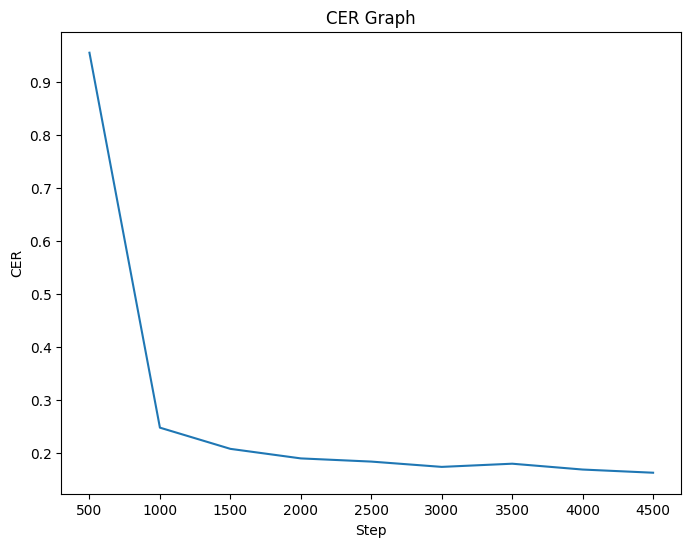

In [54]:
import matplotlib.pyplot as plt

x  = [500, 1000, 1500, 2000, 2500, 3000, 3500, 4000, 4500]
y = [0.955, 0.248, 0.208, 0.190, 0.184, 0.174, 0.180, 0.169, 0.163]
plt.figure(figsize=(8,6))
plt.plot(x, y)
plt.plot()

plt.xlabel("Step")
plt.ylabel("CER")
plt.title("CER Graph")
plt.show()

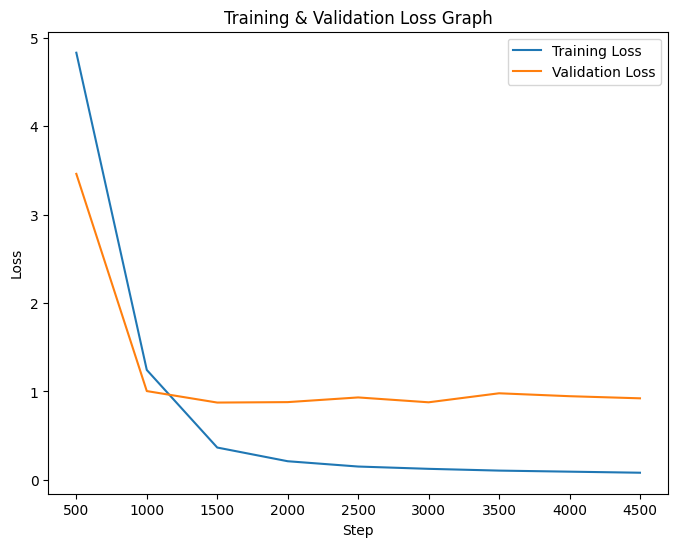

In [55]:
x  = [500, 1000, 1500, 2000, 2500, 3000, 3500, 4000, 4500]
y1 = [4.833, 1.243, 0.365, 0.210, 0.150, 0.124, 0.104, 0.092, 0.080]
y2 = [3.462, 1.004, 0.874, 0.879, 0.932, 0.877, 0.979, 0.946, 0.922]
plt.figure(figsize=(8,6))
plt.plot(x, y1, label="Training Loss")
plt.plot(x, y2, label="Validation Loss")
plt.plot()

plt.xlabel("Step")
plt.ylabel("Loss")
plt.title("Training & Validation Loss Graph")
plt.legend()
plt.show()

## 7.&nbsp;모델 저장

In [56]:
trainer.push_to_hub()

model.safetensors:   0%|          | 0.00/1.26G [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/Ljrabbit/wav2vec2-large-xls-r-300m-korean-test0/commit/8890b103da771f7b8bfa679fab65670d7e78772f', commit_message='End of training', commit_description='', oid='8890b103da771f7b8bfa679fab65670d7e78772f', pr_url=None, pr_revision=None, pr_num=None)

## 8.&nbsp;모델 평가

In [59]:
def map_to_result(batch):
  with torch.no_grad():
    input_values = torch.tensor(batch["input_values"], device="cuda").unsqueeze(0)
    logits = model(input_values).logits
  pred_ids = torch.argmax(logits, dim=-1)
  batch["pred_str"] = processor.batch_decode(pred_ids)[0]
  batch["text"] = processor.decode(batch["labels"], group_tokens=False)
  return batch

In [60]:
results = zeroth_data["test"].map(map_to_result, remove_columns=zeroth_data["test"].column_names)

Parameter 'function'=<function map_to_result at 0x0000022765C39FC0> of the transform datasets.arrow_dataset.Dataset._map_single couldn't be hashed properly, a random hash was used instead. Make sure your transforms and parameters are serializable with pickle or dill for the dataset fingerprinting and caching to work. If you reuse this transform, the caching mechanism will consider it to be different from the previous calls and recompute everything. This warning is only showed once. Subsequent hashing failures won't be showed.


Map:   0%|          | 0/457 [00:00<?, ? examples/s]

C:\Users\User\AppData\Local\Programs\Python\Python310\lib\site-packages\torch\utils\checkpoint.py:464: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.4 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  warnings.warn(
C:\Users\User\AppData\Local\Programs\Python\Python310\lib\site-packages\torch\utils\checkpoint.py:91: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(


In [61]:
print("Test CER: {:.3f}".format(cer_metric.compute(predictions=results["pred_str"], references=results["text"])))

Test CER: 0.167


In [62]:
show_random_elements(results)

,pred_str,text
0,ㄱㅓㅁㅣㅇㅑㄱㅡ ㄱㅓㅁㅣㄱㅏ ㅁㅏㄴㄷㅡㄹㅇㅓㄷㅔㄴㅡㄴ ㄱㅏㅅㅊㅓㄹ ㅁㅏㅋㅡㄴㅌㅔㄴㅌㅡㄴㅏ ㄱㅓㅁㅣ ㅈㅗㄹㅇㅡㄴ ㅇㅜㅇㅕㄴㅇㅔ ㅅㅏㅁㅁㅜㄹㅇㅣㅂㄴㅣㄲㅏ,ㄱㅓㅁㅣㅇㅘ ㄱㅡ ㄱㅓㅁㅣㄱㅏ ㅁㅏㄴㄷㅡㄹㅇㅓ ㄴㅐㄴㅡㄴ ㄱㅏㅇㅊㅓㄹㅁㅏㄴㅋㅡㅁㅇㅣㄴㅏ ㅌㅡㄴㅌㅡㄴㅎㅏㄴ ㄱㅓㅁㅣㅈㅜㄹㅇㅡㄴ ㅇㅜㅇㅕㄴㅇㅢ ㅅㅏㄴㅁㅜㄹㅇㅣㅂㄴㅣㄲㅏ
1,ㄷㅐㄴㅣㅇㅔ ㅇㅣㅁㄱㅣㄹㅛㅎㄱㅎㅔ ㅅㅐㅇㄱㅏㄱㅎㅏㄱㅗ ㅇㅣㅆㄱㅔ ㅈㅣㅁㅏㄴ ㅇㅜㄹㅣㄷㅏ ㅇㅓㄷㅣㅇㅔ ㅅㅏㄹ ㄷㅡㄴㅈㅣ ㅇㅕㅎㅜㅇㅘㄲㅔㅅㅓ ㅎㅘㅇㅅㅏㅇ ㅇㅜㄹㅣㄱㅕㅌ ㄱㅐㅅㅣㄷㅏㄴㅡㄴ ㄱㅓㄹ ㄱㅣㅇㅓㄱㅎㅏㄹㅇㅛ,ㄷㅐㄴㅣㅇㅔㄹ ㅇㅣㅁㅣ ㄱㅡㄹㅓㅎㄱㅔ ㅅㅐㅇㄱㅏㄱㅎㅏㄱㅗ ㅇㅣㅆㄱㅔㅆㅈㅣㅁㅏㄴ ㅇㅜㄹㅣㄱㅏ ㅇㅓㄷㅣㅇㅔ ㅅㅏㄹㄷㅡㄴㅈㅣ ㅇㅕㅎㅗㅇㅘㄲㅔㅅㅓ ㅎㅏㅇㅅㅏㅇ ㅇㅜㄹㅣ ㄱㅕㅌㅇㅔ ㄱㅖㅅㅣㄷㅏㄴㅡㄴ ㄱㅓㄹ ㄱㅣㅇㅓㄱㅎㅏㄹㅕㅁ
2,ㅇㅠㄱㅅㅣㅂ ㅅㅏ ㄴㅕㄴ ㅊㅗㅇㅣㄴ ㄱㅓㅁㅅㅏㄹㅗ ㅇㅣㄴㄱㅘㄴㅎㅏㄴ ㄱㅣㅁㅈㅓㄴㅅㅣㄹㅈㅏㅇㅇㅡㄴ ㅅㅣㅂ ㄴㅕㄴ ㅎㅜㅇㅣㄴ ㅊㅣㅅㅣㅂ ㅅㅏㄴㅕㄴ ㅅㅏㅇㅝㄹ ㅈㅜㄱㅏㅇ ㅈㅓㅇㅂㅗㅂㅜㅈㅏㅇ ㅂㅓㅂㄹㅠㄹ ㅂㅗㅈㅏㄱㅏㄴㅇㅡㄹㅗ ㅍㅏㄱㅕㄴㄷㅚㄱㅗ ㄱㅏㅌㅇㅡㄴㅇㅔ ㄱㅜㅇㅓㄹ ㄷㅐㄱㅗㅇ ㅅㅜㅅㅏ ㄱㅜㄱㅈㅏㅇㅇㅣ ㄷㅙㅆㄷㅏ,ㅇㅠㄱㅅㅣㅂ ㅅㅏ ㄴㅕㄴ ㅊㅗㅇㅣㅁㄱㅓㅁㅅㅏㄹㅗ ㅇㅣㅁㄱㅘㄴㅎㅏㄴ ㄱㅣㅁ ㅈㅓㄴ ㅅㅣㄹㅈㅏㅇㅇㅡㄴ ㅅㅣㅂ ㄴㅕㄴ ㅎㅜㅇㅣㄴ ㅊㅣㄹㅅㅣㅂ ㅅㅏ ㄴㅕㄴ ㅅㅏ ㅇㅝㄹ ㅈㅜㅇㅇㅏㅇㅈㅓㅇㅂㅗㅂㅜㅈㅏㅇ ㅂㅓㅂㄹㅠㄹㅂㅗㅈㅘㄱㅘㄴㅇㅡㄹㅗ ㅍㅏㄱㅕㄴㄷㅙㅆㄱㅗ ㄱㅏㅌㅇㅡㄴ ㅎㅐ ㄱㅜ ㅇㅝㄹ ㄷㅐㄱㅗㅇㅅㅜㅅㅏㄱㅜㄱㅈㅏㅇㅇㅣ ㄷㅙㅆㄷㅏ
3,ㅅㅓㄴㄷㅐㅇㅣㄴ ㄱㅡㄹㅓㄴㄷㅔ ㄴㅜㄱㅜㄴㅏ ㄴㅡㄲㅣㅅㅣㄱㅔ ㅆㅈㅣㅁㅏㄴ ㅈㅣㄱㅇㅡㄴ ㅇㅣㅊㅓㄴ ㅇㅣㅇ ㄴㅕㄴ ㅂㅜㄷㅗㅇ ㅅㅏㄴ ㅍㅗㄱㄷㅚㄴㄱㅣㄷㅐ ㅁㅗㄷㅏㄹ ㅅㅣㄱㅇㅡㄴ ㅎㅗㅇㅎㅏㅁㅇㅣㄴㄱㅏ,ㅅㅓㄴㄷㅐㅇㅣㄴ ㄱㅡㄹㅓㄴㄷㅔ ㄴㅜㄱㅜㄴㅏ ㄴㅡㄲㅣㅅㅣㄱㅔㅆㅈㅣㅁㅏㄴ ㅈㅣㄱㅡㅁ ㅇㅣㅊㅓㄴ ㅇㅠㄱ ㄴㅕㄴ ㅂㅜㄷㅗㅇㅅㅏㄴ ㅍㅗㄱㄷㅡㅇㄱㅣ ㄸㅐㅂㅗㄷㅏ ㅈㅣㄱㅡㅁ ㅎㅗㅎㅘㅇㅇㅣㄴㄱㅏ
4,ㅊㅓㄱㅂㅏㅈㅡㄴㅡㄴ ㅇㅐㄹㄹㅣㅇㅛㄹㅗ ㅇㅣㄴㅇㅐ ㅎㅐㅅㅜㅁㅕㄴ ㅇㅗㄴㄷㅗㄱㅏ ㄴㅗㅍㅏ ㄷㅐㄹㅠㅎㅕㄴㅅㅏㄴㅇㅣ ㄱㅏㅇㅎㅏㄱㅔ ㅂㅏㄹㄷㅏㄹㅏㄴㅡㄴ ㄱㅓㅈㅣㄱㅗ ㄷㅜㄱㅓㄴㅈㅔㄴㅡㄴ ㅅㅏㅇㅊㅣㄴㄱㅗㄱㅣㅇㅏㅂㅇㅣ ㅂㅏㄹㄷㅏㄹㅏㅁㅇㅔㅅㅓ ㄷㅐㄹㅛㅎㅕㄴㅅㅏㅇㅇㅡㄹ ㄷㅓ ㄱㅘㅇㅎㅏㅅㅣㄴㅡㄴ ㅇㅕㄱㅏㄹㄹㅏㄱㅗ ㅣㅆㅅㅡㅂㄴㅣㄷㅏ,ㅊㅓㅅㅂㅓㄴㅉㅐㄴㅡㄴ ㅇㅔㄹㄴㅣㄴㅛㄹㅗ ㅇㅣㄴㅎㅐ ㅎㅐㅅㅜㅁㅕㄴ ㅇㅗㄴㄷㅗㄱㅏ ㄴㅗㅍㅇㅏ ㄷㅐㄹㅠ ㅎㅕㄴㅅㅏㅇㅇㅣ ㄱㅏㅇㅎㅏㄱㅔ ㅂㅏㄹㄷㅏㄹㅎㅏㄴㅡㄴ ㄱㅓㅅㅇㅣㄱㅗ ㄷㅜㅂㅓㄴㅉㅐㄴㅡㄴ ㅅㅏㅇㅊㅡㅇ ㄱㅗㄱㅣㅇㅏㅂㅇㅣ ㅂㅏㄹㄷㅏㄹㅎㅏㅁㅕㄴㅅㅓ ㄷㅐㄹㅠ ㅎㅕㄴㅅㅏㅇㅇㅡㄹ ㄷㅓ ㄱㅏㅇㅎㅘㅅㅣㅋㅣㄴㅡㄴ ㅇㅕㄱㅎㅏㄹㅇㅡㄹ ㅎㅏㄱㅗ ㅇㅣㅆㅅㅡㅂㄴㅣㄷㅏ
5,ㅇㅣㄹㄱㅏ ㄱㅔㅅㅓㄴㅡㄴ ㄱㅡㅂㅋㅕㄱㄱㅣ ㅍㅚㄴㅊㅓㄴ ㅎㅏㄴ ㅅㅣㄴㄱㅠㅅㅣㅈㅏㅇㅇㅣ ㅌㅡㅇㅡㄷㅡㅇㅢ ㅂㅕㄴㅎㅘㄹㅗ ㅎㅚㄷㅏㅇㅅㅣㅈㅏㅇㄱㅘ ㄱㅘㄴㄹㅕㄴ ㅅㅣㅈㅏㅁㅇㅡㄹ ㅇㅟㅊㅗㄱㅅㅣㄱㅣㄴㄷㅏㄴㅇㅡㄴ ㅇㅕㅁㄹㅕㅇㅢ ㅅㅣㄱㅏㄱㄷㅗ ㅇㅣㅆㄷㅏ,ㅇㅣㄹㄱㅏㄱㅇㅔㅅㅓㄴㅡㄴ ㄱㅡㅂㄱㅕㄱㅎㅣ ㅍㅐㅇㅊㅏㅇㅎㅏㄴ ㅅㅣㄴㄱㅠ ㅅㅣㅈㅏㅇㅇㅣ ㅌㅡㄹㅔㄴㄷㅡㅇㅢ ㅂㅕㄴㅎㅘㄹㅗ ㅎㅐㄷㅏㅇ ㅅㅣㅈㅏㅇㄱㅘ ㄱㅘㄴㄹㅕㄴㅅㅣㅈㅏㅇㅇㅡㄹ ㅇㅟㅊㅜㄱ ㅅㅣㅋㅣㄴㄷㅏㄴㅡㄴ ㅇㅕㅁㄹㅕㅇㅢ ㅅㅣㄱㅏㄱㄷㅗ ㅇㅣㅆㄷㅏ
6,ㅁㅗㄱㅈㅓㄱㅇㅡㄴ ㄴㅏㄹㅇㅡㅈㅣㅁㅏㄴ ㄱㅕㄹㄱㅜㄱ ㅁㅗㄷㅜ ㅁㅕㅇㅍㅜㅁㅎㅣ ㅈㅜㄴㅡㄴ ㅂㅗㅅㅏㅇ ㅅㅣㅁ ㄴㅣㅇㅔㅅㅓ ㅇㅓㅍㅣㄹㅗㅎㄷㅙㅆㄷㅏㄴㅡㄴㄱㅔ ㅈㅓㄴㄱㅘㄷㅡㄹ ㅂㅜㄴㅅㅓㄱㅇㅣㄷㅏ,ㅁㅗㄱㅈㅓㄱㅇㅡㄴ ㄷㅏㄹㅡㅈㅣㅁㅏㄴ ㄱㅕㄹㄱㅜㄱ ㅁㅗㄷㅜ ㅁㅕㅇㅍㅜㅁㅇㅣ ㅈㅜㄴㅡㄴ ㅂㅗㅅㅏㅇㅅㅣㅁㄹㅣㅇㅔㅅㅓ ㅂㅣㄹㅗㅅㄷㅙㅆㄷㅏㄴㅡㄴ ㄱㅔ ㅈㅓㄴㅁㅜㄴㄱㅏㄷㅡㄹ ㅂㅜㄴㅅㅓㄱㅇㅣㄷㅏ
7,ㄷㅗㄱㅣㄹㅡㄹ ㅂㅗㅎㅗㅎㅘㄱㅣ ㅇㅟㅇㅘㅇㅇㅕ ㅎㅚㅆㅡㄴㅢ ㅇㅑㅎㅏㅇ ㅇㅣㅂㅐㄱ ㅁㅏㄴㅁㅕㅇㅇㅢ ㅇㅣㄴㅁㅕㅇㅇㅡㄴㄹ ㅇㅏㅅㅏㄱㅏㄴㅡㄴ ㅇㅣㄹㅡㄹ ㅈㅜㅇㅟ ㅎㅏㅇㅣㄴㅡㄴㄷㅔ ㄱㅡ ㅈㅜㅇ ㄷㅐㅂㅜ ㅂㅜㄴㅣ ㅇㅠㄷㅐㅇㅣㄴㅣㅇㅓㅆㅅㅡㅂㄴㅣㄷㅏ,ㄷㅗㄱㅇㅣㄹㅇㅡㄹ ㅂㅗㅎㅗㅎㅏㄱㅣ ㅇㅟㅎㅏㅇㅕ ㅎㅚㅅㅡㄴㅡㄴ ㅇㅑㄱ ㅇㅣㅂㅐㄱ ㅁㅏㄴ ㅁㅕㅇㅇㅢ ㅇㅣㄴㅁㅕㅇㅇㅡㄹ ㅇㅏㅅㅇㅏ ㄱㅏㄴㅡㄴ ㅇㅣㄹㅇㅡㄹ ㅈㅣㅎㅟㅎㅏㅇㅕㅆㄴㅡㄴㄷㅔ ㄱㅡㅈㅜㅇ ㄷㅐㅂㅜㅂㅜㄴㅇㅣ ㅇㅠㄷㅐㅇㅣㄴㅇㅣㅇㅓㅆㅅㅡㅂㄴㅣㄷㅏ
8,ㄷㅓㅇㅗㄱㅇㅣ ㅇㅗㄹㅔ ㅎㅏㅘㄴㄱㅣ ㅁㅣㄱㅜ ㄱㅡㅁㄴㅣㅇㄴㅅㅏㅇㅇㅣ ㅇㅖㄱㅗㄷㅙ ㅇㅣㅆㅇㅓ ㄱㅡㅁㄴㅣㄹㅡㄹ ㄷㅓ ㄴㅐㄹㅕㅆㄷㅏㄱㅏㄴ ㅈㅏㅈㅊㅣ ㅊㅏㅂㅡㄴ ㄴㅜㅊㅜㄹㅇㅣ ㄱㅓㅅㅔㅈㅣㄹ ㅅㅜ ㅇㅣㅆㄷㅏㄴㅡㄴ ㅈㅓㅁㄷㅗ ㄱㅡㅁㄴㅣㅇㅣㄴㅏㅇㅢ ㅂㅜㄷㅏㅁㅇㅡㄹ ㅈㅜㄱㅗ ㅇㅣㅆㅅㅡㅂㄴㅣㄷㅏ,ㄷㅓㅇㅜㄱㅇㅣ ㅇㅗㄹㅎㅐ ㅎㅏㅂㅏㄴㄱㅣ ㅁㅣㄱㅜㄱ ㄱㅡㅁㄹㅣㅇㅣㄴㅅㅏㅇㅇㅣ ㅇㅖㄱㅗㄷㅙ ㅇㅣㅆㅇㅓ ㄱㅡㅁㄹㅣㄹㅡㄹ ㄷㅓ ㄴㅐㄹㅕㅆㄷㅏㄱㅏㄴ ㅈㅏㅊㅣㅅ ㅈㅏㅂㅗㄴ ㅇㅠㅊㅜㄹㅇㅣ ㄱㅓㅅㅔㅈㅣㄹ ㅅㅜ ㅇㅣㅆㄷㅏㄴㅡㄴ ㅈㅓㅁㄷㅗ ㄱㅡㅁㄹㅣ ㅇㅣㄴㅎㅏㅇㅔ ㅂㅜㄷㅏㅁㅇㅡㄹ ㅈㅜㄱㅗ ㅇㅣㅆㅅㅡㅂㄴㅣㄷㅏ
9,ㅁㅁㅣㄷㅣㅇㅓㄱㅓ ㄱㅓㄹㅐㅅㅓㄴ ㅈㅓㅇㄴㅇㅛㄴㄱㅗㄴㄱㅏㄴㅇㅡㄹ ㅊㅣㅅㅣㅂ ㅍㅓㅅㅔㄴㅌㅡㄹㅗ ㅎㅏㄱㄷㅐㅎㅏㄱㅗ ㄱㅏㄱ ㅊㅏㅁㅅㅓㄱㅈㅏㅇㅢ ㅍㅣㄹㅛㅎㅐㅆㄷㅏㄹㅡㄴ ㅈㅓㄴㅅㅣ ㅂㅗㅇㄱㅏㄴㅇㅡㄹㅗ ㄱㅣㅎㅐㄱㅎㅏㄴ ㄱㅓㅅㅇㅣ ㅌㅡㅈㅣㅇㅛ,ㅁㅣㄷㅣㅇㅓㅇㅘ ㄱㅓㄹㅐㅅㅓㄴ ㅈㅓㄴㅇㅛㅇ ㄱㅗㅇㄱㅏㄴㅇㅡㄹ ㅊㅣㄹㅅㅣㅂ ㅍㅓㅅㅔㄴㅌㅡㄹㅗ ㅎㅘㄱㄷㅐㅎㅏㄱㅗ ㄱㅏㄱ ㅊㅏㅁㅅㅓㄱㅈㅏㅇㅢ ㅍㅣㄹㅇㅛㅇㅔ ㄸㅏㄹㅡㄴ ㅈㅓㄴㅅㅣㄱㅗㅇㄱㅏㄴㅇㅡㄹㅗ ㄱㅣㅎㅚㄱㅎㅏㄴ ㄱㅓㅅㅇㅣ ㅌㅡㄱㅈㅣㅇ


In [63]:
def make_words(batch):
  batch['pred_str'] = join_jamos(batch['pred_str'])
  batch['text'] = join_jamos(batch['text'])
  return batch

In [64]:
results = results.map(make_words)

Map:   0%|          | 0/457 [00:00<?, ? examples/s]

In [65]:
show_random_elements(results)

,pred_str,text
0,한구 그냉에 따르며 장련말 힌제 가게 진용 잔핵은 천 상백 사십 사조 상천 억은으로 이 가운데 약 십 산퍼센트가 마인어스 통정등 대출로 추선든다,한국은행에 따르면 작년 말 현재 가계신용 잔액은 천 삼백 사십 사 조 삼천 억원으로 이 가운데 약 십 삼 퍼센트가 마이너스통장 등 대출로 추산된다
1,선대인 그런데 누구나 느끼시게 ㅆ지만 직은 이천 잉 년 부동 산 폭된기대 모달 식은 홍함인가,선대인 그런데 누구나 느끼시겠지만 지금 이천 육 년 부동산 폭등기 때보다 지금 호황인가
2,연고 지는 앙에 에서 이전자 벼니게 이라날 가능성이 일퍼센트미만이 것이라고 추장한고 이씁니다,연구진은 아이에게서 유전자 변이가 일어날 가능성이 일 퍼센트 미만일 것으로 추정하고 있습니다
3,틐히 중소영 빌딩은 개인투자자의 전폭적인 제질을 받고 있다,특히 중소형 빌딩은 개인투자자의 전폭적인 지지를 받고 있다
4,그렇게 해주시면 후보들은 정책과 비전을 가지고 국민 드게 세로온 데함민 국으리 어떻게 만딜 것인지,그렇게 해주시면 후보들은 정책과 비전을 가지고 국민들에게 새로운 대한민국을 어떻게 만들 것인지
5,옇우민 ㄴ대이는 모든 문가 차먼이 닺쳐 있었고 줄변에는 감식ㅋ함에라가 있었다며 이유 똘러 부터 오래 동한 자우 외이 처가시꾸를 보지 못했다는 말을 드어다며아며오 전 했다,여우밍레이는 모든 문과 창문이 닫혀 있었고 주변에는 감시카메라가 있었다며 이웃들로부터 오랫동안 자오웨이 처가 식구를 보지 못했다는 말을 들었다며며 전했다
6,그리스티의 청박장이 는 여전히 우리 모두에게 도전이 되는 것입니다,크리스티의 청각 장애는 여전히 우리 모두에게 도전이 되는 것입니다
7,작 년 십 잉 월 천 이백 십 언대가지 올랐던 ㅇ원단러 하뉼은 쵝은 천댁 오십언 때로 오퍼센트 가령 떨어지면서 뇌국인 자금 유이르 모물 주고 있다,작년 십 이 월 천 이백 십 원대까지 올랐던 원 달러 환율은 최근 천 백 오십 원대로 오 퍼센트가량 떨어지면서 외국인 자금 유입에 도움을 주고 있다
8,노예로끌 려온 ㅏㅏ는 사람들은 수사스릐 묵겨 구차를 당하고 나기니 지켰으며 그후 냉 킬로미터에 다라는 노예의 기를 걸어가야 했습니다,노예로 끌려 온 많은 사람들은 쇠사슬에 묶여 구타를 당하고 낙인이 찍혔으며 그 후 네 킬로미터에 달하는 노예의 길을 걸어가야 했습니다
9,박 대통련은 위민관 삼층 영상 국무ㅢ 이실에서 찬모들과 머리이 맞대곡 정북 추수책을 농이한다고 한다,박 대통령은 위민관 삼 층 영상국무회의실에서 참모들과 머리를 맞대고 정국 수습책을 논의한다고 한다


In [66]:
model.to("cuda")
with torch.no_grad():
  logits = model(torch.tensor(zeroth_data["test"][:1]["input_values"], device="cuda")).logits
pred_ids = torch.argmax(logits, dim=-1)

In [67]:
" ".join(processor.tokenizer.convert_ids_to_tokens(pred_ids[0].tolist()))

'[PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] ㅊ [PAD] ㅣ [PAD] ㄴ [PAD] [PAD] ㅏ ㅏ ㄴ [PAD] ㅇ ㅇ ㅢ | | [PAD] ㅅ [PAD] [PAD] [PAD] ㅏ [PAD] ㅁ [PAD] ㅇ [PAD] ㅓ [PAD] [PAD] [PAD] ㄹ [PAD] | | [PAD] [PAD] [PAD] [PAD] [PAD] ㄱ [PAD] ㅣ ㅁ [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] ㅈ [PAD] [PAD] ㅓ ㄴ [PAD] [PAD] [PAD] [PAD] ㅈ [PAD] [PAD] ㅏ ㅇ [PAD] [PAD] [PAD] [PAD] ㄱ [PAD] [PAD] ㅘ ㄴ [PAD] [PAD] ㅇ ㅇ ㅔ | | [PAD] [PAD] ㄷ [PAD] [PAD] ㅗ ㅇ ㅇ [PAD] [PAD] [PAD] [PAD] ㄹ [PAD] ㅛ [PAD] [PAD] [PAD] ㅇ ㅇ ㅣ [PAD] ㄴ [PAD] | | [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] ㅈ [PAD] [PAD] ㅏ [PAD] ㅇ [PAD] [PAD] [PAD] [PAD] [PAD] ㄷ [PAD] ㅗ [PAD] ㅇ [PAD] [PAD] [PAD] [PAD] ㅇ ㄴ [PAD] [PAD] ㅕ [PAD] ㄴ | | [PAD] [PAD] ㅎ [PAD] ㅗ [PAD] ㅇ [PAD] [PAD] ㅎ ㅣ [PAD] ㄱ [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] ㄷ [PAD] [PAD] ㅐ [PAD] | | [PAD] ㄱ [PAD] [PAD]